# Analysis of co-contraction

In [1]:
import pingouin as pg
import matplotlib.pyplot as plt
import os
import h5py
import pandas as pd
import numpy as np
import scipy.signal as signal

# define style for figures
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")

In [ ]:
# load in emg data
# Read in training data
root_directory = os.path.join(os.getcwd(), 'grouped')

# participants
participants = [f"E{str(i).zfill(2)}" for i in range(1, 21)]  # Generates ['E01', 'E02', ..., 'E20']

# data to read in: SN, BN
all_data = []

SN=0
for p in participants:
    SN += 1
    root_subject = os.path.join(root_directory, p)  # Now looking inside "grouped/E01", "grouped/E02", etc.
    calib_folders = [f.path for f in os.scandir(root_subject) if f.is_dir() and f.name.startswith('calibration')] # Find subfolders starting with "calibration"

    # Extract c_min and c_max from the last calibration folder
    if calib_folders:
        calib_folders.sort()  # Ensure the folders are sorted
        last_calib = calib_folders[-1]  # Get the last calibration folder

        with h5py.File(os.path.join(last_calib, 'c_min.hdf5'), 'r') as f:
            c_min = f['0'][0:]
        with h5py.File(os.path.join(last_calib, 'c_max.hdf5'), 'r') as f:
            c_max = f['0'][0:]

    
    control_folders = [f.path for f in os.scandir(root_subject) if f.is_dir() and f.name.startswith('control')] # Find subfolders starting with "control"
    BN = 0
    for b in control_folders:
        fb = []
        # Read and store in everything
        BN += 1
        if os.path.isfile(os.path.join(b, 'trials.csv')):
            trials = pd.read_csv(os.path.join(b, 'trials.csv'),)
        if os.path.isfile(os.path.join(b, 'data_raw.hdf5')):
            data_raw = h5py.File(os.path.join(b, 'data_raw.hdf5'),)
        if os.path.isfile(os.path.join(b, 'data_proc.hdf5')):
            data_proc = h5py.File(os.path.join(b, 'data_proc.hdf5'),)
        if os.path.isfile(os.path.join(b, 'cursor_position.hdf5')):
            cursor_position = h5py.File(os.path.join(b, 'cursor_position.hdf5'),) 
        if os.path.isfile(os.path.join(b, 'error.hdf5')):
            error = h5py.File(os.path.join(b, 'error.hdf5'),)
        if os.path.isfile(os.path.join(b, 'error_feedback.hdf5')):
            error_feedback = h5py.File(os.path.join(b, 'error_feedback.hdf5'),)
        if os.path.isfile(os.path.join(b, 'wave.hdf5')):
            wave = h5py.File(os.path.join(b, 'wave.hdf5'),)

        all_data.append({
        "SN": SN,
        "BN": BN,
        "c_min": c_min if 'c_min' in locals() else None,
        "c_max": c_max if 'c_max' in locals() else None,
        "trials": pd.read_csv(os.path.join(b, 'trials.csv')) if os.path.isfile(os.path.join(b, 'trials.csv')) else None,
        "data_raw": h5py.File(os.path.join(b, 'data_raw.hdf5')) if os.path.isfile(os.path.join(b, 'data_raw.hdf5')) else None,
        "data_proc": h5py.File(os.path.join(b, 'data_proc.hdf5')) if os.path.isfile(os.path.join(b, 'data_proc.hdf5')) else None,
        })
    
# data

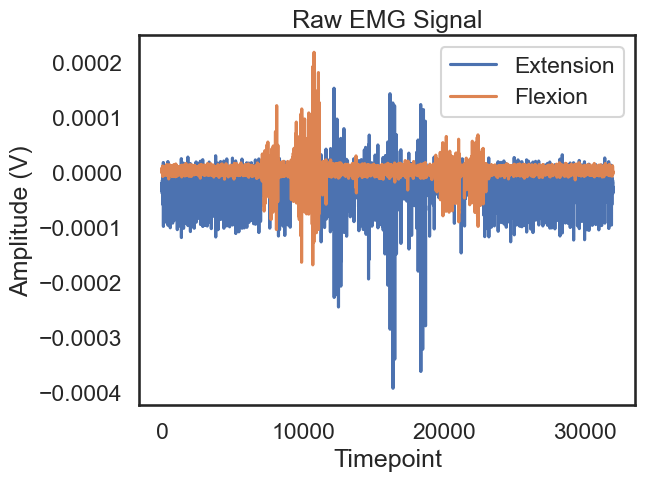

In [3]:
import matplotlib.pyplot as plt

selected_SN = 12   # Change this to the SN you want
selected_BN = 5   # Change this to the BN you want

# Find the matching entry in the data list
selected_entry = next((entry for entry in all_data if entry["SN"] == selected_SN and entry["BN"] == selected_BN), None)
data_raw = selected_entry["data_raw"] 

# plot raw data
sns.lineplot(data=data_raw['1'][0:][0], label='Extension')
sns.lineplot(data=data_raw['1'][0:][1], label='Flexion')
plt.xlabel('Timepoint')
plt.ylabel('Amplitude (V)')
plt.title('Raw EMG Signal')
plt.legend()
# when you plot the data, the first [] have the trial number as a string (!), the next have the timepoints, and then the channel

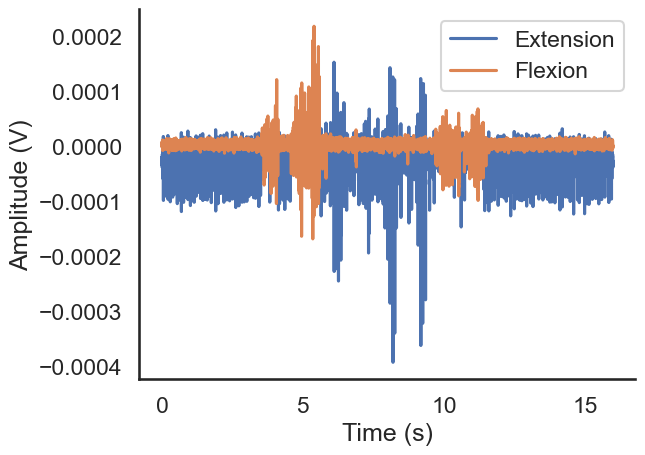

In [4]:
# To plot over time
sampling_rate = 2000  # Hz
time_vector = [i / sampling_rate for i in range(len(data_raw['1'][0:][1]))]  # Time in seconds

sns.lineplot(x=time_vector, y=data_raw['1'][0:][0], label='Extension')  # First line
sns.lineplot(x=time_vector, y=data_raw['1'][0:][1], label='Flexion')   # Second line
sns.despine()

# plt.title('Raw EMG Signal')
plt.xlabel('Time (s)')  # Update x-axis label to indicate seconds
plt.ylabel('Amplitude (V)')
plt.legend()

### Bandpass filter

Extension Signal Shape: (32000,)
Flexion Signal Shape: (32000,)


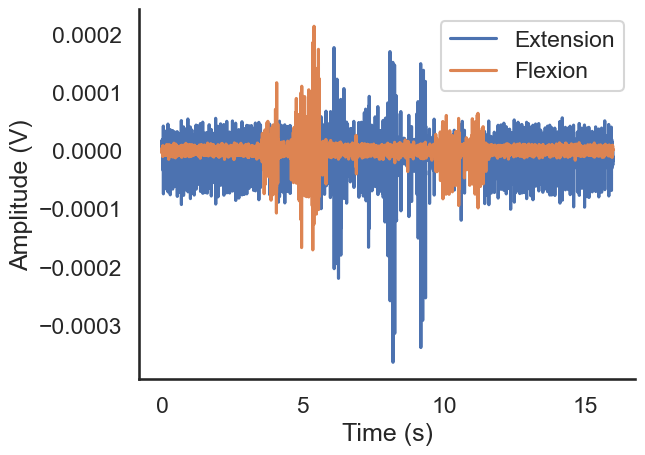

In [5]:
# Define the Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = fs/2  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut=10, highcut=500, fs=2000, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return signal.filtfilt(b, a, data)

# Sampling frequency
fs = 2000  # Hz
time_vector = [i / fs for i in range(len(data_raw['1'][0:][1]))]  # Time in seconds

# Extract raw data from HDF5 dataset
extension_signal = np.array(data_raw['1'][0, :])  # First row
flexion_signal = np.array(data_raw['1'][1, :])   # Second row

print(f"Extension Signal Shape: {extension_signal.shape}")  # Should be (32000,)
print(f"Flexion Signal Shape: {flexion_signal.shape}")  # Should be (32000,)

# Apply the bandpass filter
filtered_extension = apply_filter(extension_signal, fs=fs)
filtered_flexion = apply_filter(flexion_signal, fs=fs)

# Plot the filtered signals
sns.lineplot(x=time_vector, y=filtered_extension, label='Extension')
sns.lineplot(x=time_vector, y=filtered_flexion, label='Flexion')
sns.despine()

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
# plt.title('Filtered Signals (10-500 Hz Bandpass)')
plt.legend()
plt.show()

### MAV (mean absolute value) with a 750 ms window

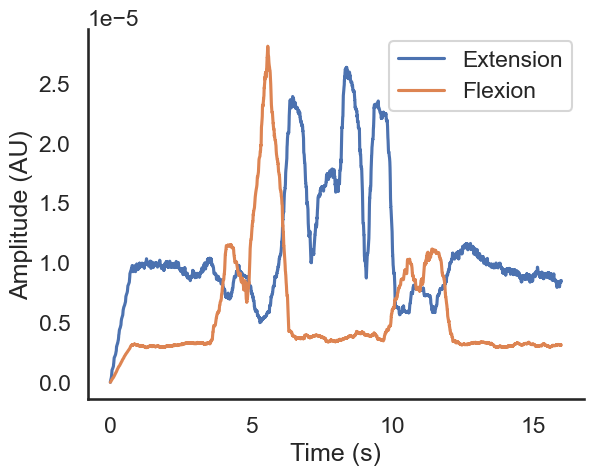

In [6]:
def compute_mav(signal, fs, window_ms):
    window_size = int(window_ms * fs / 1000)  # Convert ms to samples
    mav = np.convolve(np.abs(signal), np.ones(window_size)/window_size, mode='full')[:len(signal)]
    return mav

# Compute MAV with 750 ms window
window_ms = 750     # ms
mav_extension = compute_mav(filtered_extension, fs, window_ms)
mav_flexion = compute_mav(filtered_flexion, fs, window_ms)

# Time vector adjusted to MAV length
mav_time = time_vector[:len(mav_extension)]

# Plot the MAV signals
sns.lineplot(x=mav_time, y=mav_extension, label='Extension')
sns.lineplot(x=mav_time, y=mav_flexion, label='Flexion')
sns.despine()

# plt.xticks(np.arange(0, 17, 2)) 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (AU)')
# plt.title('MAV (750 ms Window)')
plt.legend()
plt.show()

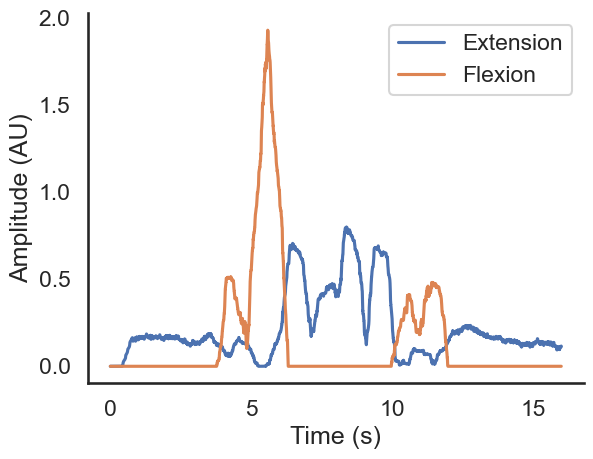

In [7]:
# Find the correct SN in the data
selected_data = next(item for item in all_data if item["SN"] == selected_SN)

# Extract c_min and c_max for the selected SN
c_min_ext = selected_data["c_min"][0]
c_max_ext = selected_data["c_max"][0]
c_min_flex = selected_data["c_min"][1]
c_max_flex = selected_data["c_max"][1]

# To normalise the data min - max 
def normalise(signal, min, max):
    signal_norm = (signal - min) / (max - min)
    signal_norm[signal_norm < 0] = 0.0
    return signal_norm

norm_extension = normalise(mav_extension, c_min_ext, c_max_ext)
norm_flexion = normalise(mav_flexion, c_min_flex, c_max_flex)

# Plot the MAV signals
sns.lineplot(x=mav_time, y=norm_extension, label='Extension')
sns.lineplot(x=mav_time, y=norm_flexion, label='Flexion')
sns.despine()

# plt.xticks(np.arange(0, 17, 2)) 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (AU)')
# plt.title('Normalised from raw data')
plt.legend()
plt.show()

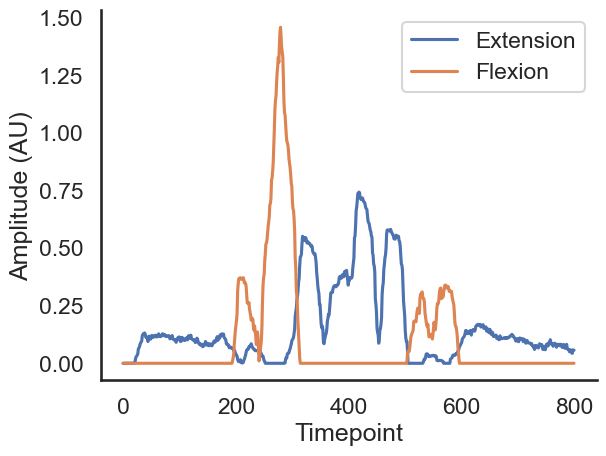

In [8]:
# Find the matching entry in the data list
selected_entry = next((entry for entry in all_data if entry["SN"] == selected_SN and entry["BN"] == selected_BN), None)
data_proc = selected_entry["data_proc"] 

# plot processed data 
sns.lineplot(data=data_proc['1'][0:][0], label='Extension')
sns.lineplot(data=data_proc['1'][0:][1], label='Flexion')
sns.despine()

plt.xlabel('Timepoint')
plt.ylabel('Amplitude (AU)')
# plt.title('Processed EMG Signal')
plt.legend()

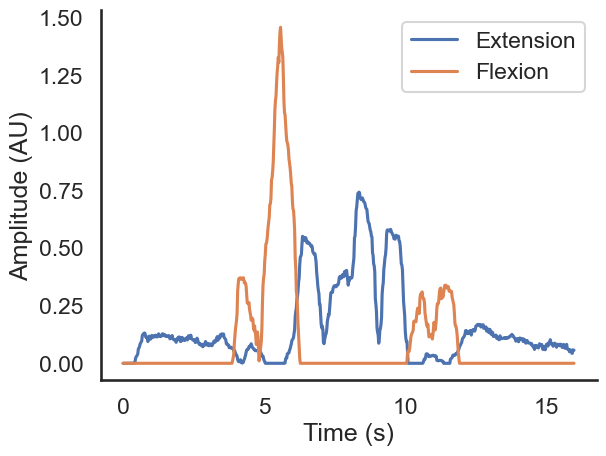

In [9]:
# To have it over time
sampling_rate = 50  # Hz
time_vector = [i / sampling_rate for i in range(len(data_proc['1'][0:][1]))]  # Time in seconds

sns.lineplot(x=time_vector, y=data_proc['1'][0:][0], label='Extension')  # First line
sns.lineplot(x=time_vector, y=data_proc['1'][0:][1], label='Flexion')   # Second line
sns.despine()

plt.xlabel('Time (s)')  # Update x-axis label to indicate seconds
plt.ylabel('Amplitude (AU)')
# plt.title('Processed EMG Signal')
plt.legend()

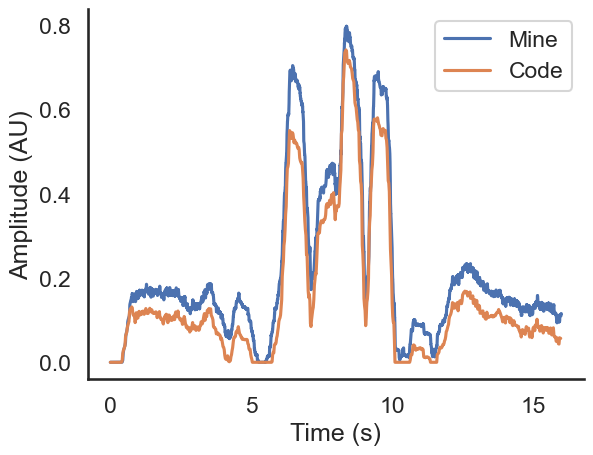

In [10]:
# Plot the MAV signals
sns.lineplot(x=mav_time, y=norm_extension, label='Mine')
sns.lineplot(x=time_vector, y=data_proc['1'][0:][0], label='Code')  # First line
sns.despine()

# plt.xticks(np.arange(0, 17, 2)) 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (AU)')
# plt.title('Normalised from raw data')
plt.legend()
plt.show()

CCI1 and CCI2

In [11]:
# Invented numbers for (lower/higher)*(lower+higher) at one point in time
print('CCI1 =', (0.1/0.9)*(0.1+0.9))
print('CCI1 =', (1/1)*(1+1))

# Sanme numbers for (2*lower)/(lower+higher)
print('CCI2 =', 2*0.1/(0.1+0.9))
print('CCI2 =', 2*0.1/(0.1+0.1))

CCI1 = 0.11111111111111112
CCI1 = 2.0
CCI2 = 0.2
CCI2 = 1.0


### Choose CCI1 gives a zero when both are small

C:\Users\merin\AppData\Local\Temp\ipykernel_34440\561929754.py:6: RuntimeWarning: invalid value encountered in divide
  cci = (lower/higher)*(lower+higher)


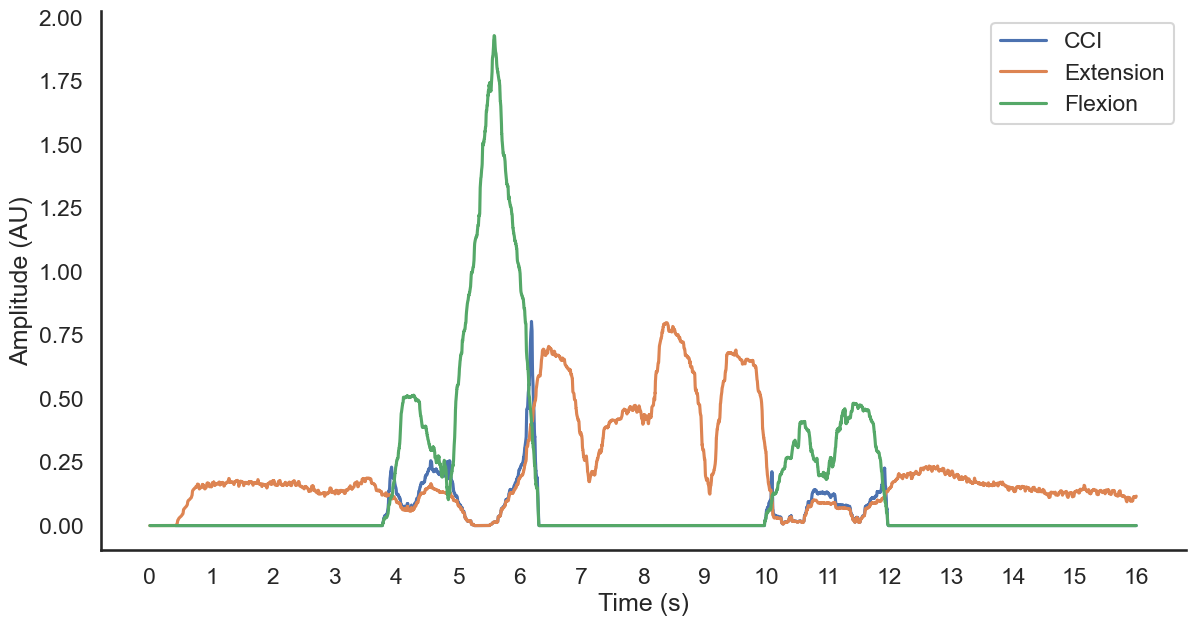

In [12]:
# Compute lower and higher values at each time point
lower = np.minimum(norm_extension, norm_flexion)
higher = np.maximum(norm_extension, norm_flexion)

# Compute CCI
cci = (lower/higher)*(lower+higher) 

# Plot CCI vs. time
plt.figure(figsize=(14, 7))
sns.lineplot(x=mav_time, y=cci, label='CCI')
sns.lineplot(x=mav_time, y=norm_extension, label='Extension')
sns.lineplot(x=mav_time, y=norm_flexion, label='Flexion')
sns.despine()

plt.xticks(np.arange(0, 17, 1))  # Ensure integer x-axis labels
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (AU)')
# plt.title('Co-Contraction Index (CCI) Over Time')
plt.legend()
plt.show()

From the processed data

C:\Users\merin\AppData\Local\Temp\ipykernel_34440\2050958650.py:12: RuntimeWarning: invalid value encountered in divide
  cci = (lower/higher)*(lower+higher)


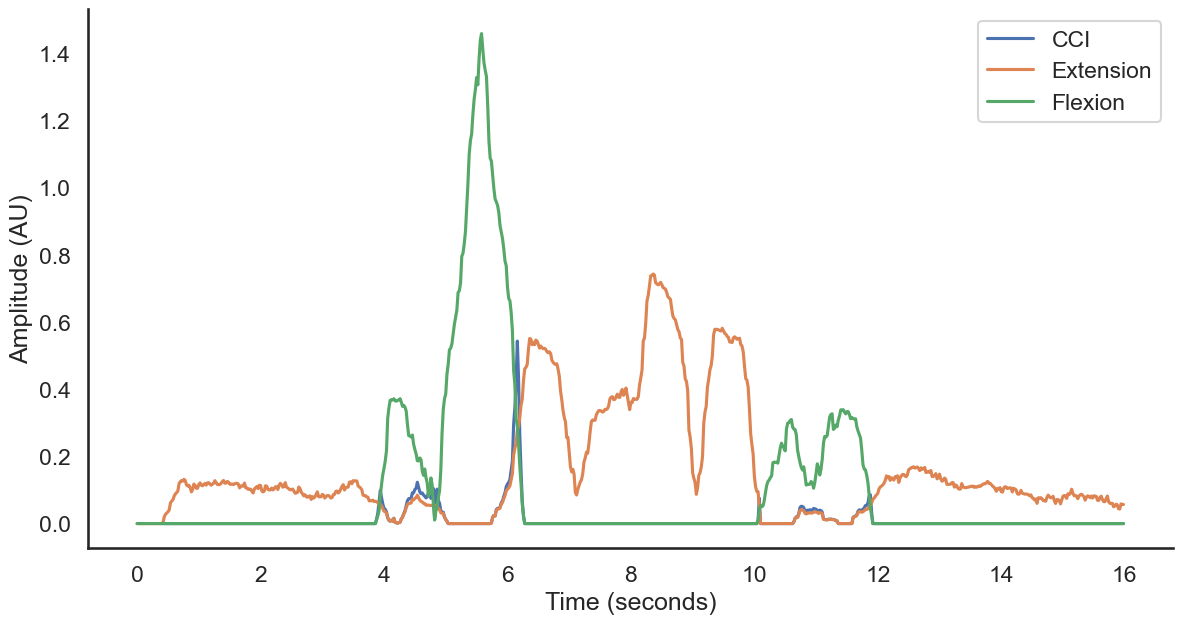

In [13]:
ext =  np.array(data_proc['1'][0, :])  # First line
flex = np.array(data_proc['1'][1, :])   # Second row

sampling_rate = 50  # Hz
time_vector = [i / sampling_rate for i in range(len(data_proc['1'][0:][1]))]  # Time in seconds

# Compute lower and higher values at each time point
lower = np.minimum(ext, flex)
higher = np.maximum(ext, flex)

# Compute CCI
cci = (lower/higher)*(lower+higher) 

# Plot CCI vs. time
plt.figure(figsize=(14, 7))
sns.lineplot(x=time_vector, y=cci, label='CCI')
sns.lineplot(x=time_vector, y=ext, label='Extension')
sns.lineplot(x=time_vector, y=flex, label='Flexion')

plt.xticks(np.arange(0, 17, 2))  # Ensure integer x-axis labels
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (AU)')
# plt.title('Co-Contraction Index (CCI) Over Time')
plt.legend()
sns.despine()
plt.show()

## All trials, all participants

Get the merged dataframe

In [14]:
# Get the current directory where the script is running
current_directory = os.getcwd()

# Get a list of all the participant folders (assuming they are all in the same directory)
participants_folders = sorted([f for f in os.listdir(current_directory) if os.path.isdir(f)])

# Initialize an empty list to store data
merged = []

SN = 0  # Subject Number counter

# Loop through each participant folder
for folder in participants_folders:
    SN += 1  # Increment Subject Number
    file_path = os.path.join(current_directory, folder, "all_trials.csv")  # Path to all_trials.csv
    
    if os.path.isfile(file_path):  # Check if the file exists
        data_temp = pd.read_csv(file_path)  # Read the CSV file

        # Insert the Subject Number (SN) as the first column
        data_temp.insert(0, "SN", SN)

        # Append to the list of data
        merged.append(data_temp)

# Merge all data into a single DataFrame
merged_df = pd.concat(merged, ignore_index=True)

# Save to a new CSV file
merged_df.to_csv("merged_all_trials.csv", index=False)

# Drop column 'trial and emg'
merged_df = merged_df.drop('trial', axis=1)
merged_df = merged_df.drop('emg', axis=1)

# Renaming columns
merged_df.rename(columns={'rate': 'SoA'}, inplace=True)

# Apply Min-Max scaling within each SN group
merged_df["SoA_normalized"] = merged_df.groupby("SN")["SoA"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

print(merged_df)

      SN  assistance  block     score  score_feedback  SoA  SoA_normalized
0      2        0.00      1  0.405413        0.405413    3           0.250
1      2        0.50      1  0.219117        0.609558    1           0.000
2      2        0.10      1  0.310939        0.379845    3           0.250
3      2        0.25      1 -0.234162        0.074379    3           0.250
4      2        0.25      1  0.098003        0.323502    6           0.625
...   ..         ...    ...       ...             ...  ...             ...
2395  21        0.10      6  0.240152        0.316137    6           0.250
2396  21        0.00      6  0.445145        0.445145    7           0.500
2397  21        0.10      6  0.436270        0.492643    7           0.500
2398  21        0.25      6  0.124769        0.343577    7           0.500
2399  21        0.50      6  0.073693        0.536846    7           0.500

[2400 rows x 7 columns]


Convert to csv to be able to open it and compare. No need to have this in the main code. Just a check for me

In [15]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_data)

# Save the DataFrame to a CSV file
df.to_csv("data.csv", index=False)

### CCI for each trial from raw data

In [16]:
from scipy import signal

# Define the Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = fs/2  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut=10, highcut=500, fs=2000, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return signal.filtfilt(b, a, data)

def compute_mav(signal, fs, window_ms):
    window_size = int(window_ms * fs / 1000)  # Convert ms to samples
    mav = np.convolve(np.abs(signal), np.ones(window_size)/window_size, mode='full')[:len(signal)]
    return mav

# To normalise the data min - max 
def normalise(signal, min, max):
    signal_norm = (signal - min) / (max - min)
    signal_norm[signal_norm < 0] = 0.0
    return signal_norm

def calculate_cci(lower, higher):
    if higher == 0 or np.isnan(higher):
        return 0
    else:
        return (lower / higher) * (lower + higher)

# To append the results and convert to csv for me
data2 = []

for selected_SN in range(1, 21):
    # Find the correct SN in the data
    selected_data = next(item for item in all_data if item["SN"] == selected_SN)

    if selected_SN == 6: # The only participant left handed, for which the channels were interchanged
        c_min_ext = selected_data["c_min"][1] 
        c_max_ext = selected_data["c_max"][1]
        c_min_flex = selected_data["c_min"][0]
        c_max_flex = selected_data["c_max"][0]
    else:
        # Extract c_min and c_max for the selected SN
        c_min_ext = selected_data["c_min"][0]
        c_max_ext = selected_data["c_max"][0]
        c_min_flex = selected_data["c_min"][1]
        c_max_flex = selected_data["c_max"][1]

    for selected_BN in range(1, 7):  
        
        selected_entry = next((entry for entry in all_data if entry["SN"] == selected_SN and entry["BN"] == selected_BN), None)
        data_raw = selected_entry["data_raw"]          
        # print(selected_SN, selected_BN)

        for i in range(20):   
            # print(data_raw.keys())  
            i_str = str(i)  # Convert i to string
            
            # Extract raw data from HDF5 dataset
            extension_signal = np.array(data_raw[i_str][0, :])  # First row
            flexion_signal = np.array(data_raw[i_str][1, :])   # Second row

            # Apply the bandpass filter
            filtered_extension = apply_filter(extension_signal, fs=2000)
            filtered_flexion = apply_filter(flexion_signal, fs=2000)

            # Compute MAV with 750 ms window
            window_ms = 750  # ms
            mav_extension = compute_mav(filtered_extension, fs=2000, window_ms=window_ms)
            mav_flexion = compute_mav(filtered_flexion, fs=2000, window_ms=window_ms)

            # Normalize from min max from calibration
            norm_extension = normalise(mav_extension, c_min_ext, c_max_ext)
            norm_flexion = normalise(mav_flexion, c_min_flex, c_max_flex)

            # Compute lower and higher values at each time point
            lower = np.minimum(norm_extension, norm_flexion)
            higher = np.maximum(norm_extension, norm_flexion)

            cci = np.zeros_like(higher)  

            for i in range(len(higher)):
                if higher[i] == 0 or np.isnan(higher[i]):
                    cci[i] = 0
                else:
                    cci[i] = (lower[i] / higher[i]) * (lower[i] + higher[i])

            ########## Truncate the signals from 5625 to 20625 data points (second 3 to 11)
            trunc_extension_signal = extension_signal[5625:20625]
            trunc_flexion_signal = flexion_signal[5625:20625]

            # Apply the bandpass filter to the truncated signals
            filtered_trunc_extension = apply_filter(trunc_extension_signal, fs=2000)
            filtered_trunc_flexion = apply_filter(trunc_flexion_signal, fs=2000)

            # Compute MAV with 750 ms window for truncated signals
            mav_trunc_extension = compute_mav(filtered_trunc_extension, fs=2000, window_ms=window_ms)
            mav_trunc_flexion = compute_mav(filtered_trunc_flexion, fs=2000, window_ms=window_ms)

            # Normalize the truncated signals using global mean and std
            norm_trunc_extension = normalise(mav_trunc_extension, c_min_ext, c_max_ext)
            norm_trunc_flexion = normalise(mav_trunc_flexion, c_min_flex, c_max_flex)

            # Compute lower and higher values at each time point for truncated signals
            lower_trunc = np.minimum(norm_trunc_extension, norm_trunc_flexion)
            higher_trunc = np.maximum(norm_trunc_extension, norm_trunc_flexion)

            cci_trunc = np.zeros_like(higher_trunc)  
            # Compute CCI for truncated signals
            for i in range(len(higher_trunc)):
                if higher_trunc[i] == 0 or np.isnan(higher_trunc[i]):
                    cci_trunc[i] = 0
                else:
                    cci_trunc[i] = (lower_trunc[i] / higher_trunc[i]) * (lower_trunc[i] + higher_trunc[i])


            # cci_trunc = (lower_trunc/higher_trunc) * (lower_trunc + higher_trunc)
            # cci_trunc = calculate_cci(lower_trunc, higher_trunc)

            data2.append({
                "SN": selected_SN,
                "Block": selected_BN,
                "Trial": i,
                "CCI": cci,
                "CCI_Truncated": cci_trunc,
            })

#### Same from processed data

In [17]:
from_proc = [] 

for selected_SN in range(1, 21):
    for selected_BN in range(1, 7):  
        selected_entry = next((entry for entry in all_data if entry["SN"] == selected_SN and entry["BN"] == selected_BN), None)
        data_proc = selected_entry["data_proc"]      
        # print(selected_SN, selected_BN)

        for i in range(20):   
            i_str = str(i)  # Convert i to string
            ext =  np.array(data_proc[i_str][0, :])  # First line
            flex = np.array(data_proc[i_str][1, :])   # Second row

            # Compute lower and higher values at each time point
            lower = np.minimum(ext, flex)
            higher = np.maximum(ext, flex)

            cci = np.zeros_like(higher)  

            for i in range(len(higher)):
                if higher[i] == 0 or np.isnan(higher[i]):
                    cci[i] = 0
                else:
                    cci[i] = (lower[i] / higher[i]) * (lower[i] + higher[i])

            # # Compute CCI
            # # cci = (2 * lower) / (lower + higher)
            # cci = (lower/higher)*(lower+higher) 

            from_proc.append({
                "SN": selected_SN,
                "Block": selected_BN,
                "Trial": i,
                "CCI": cci,
            })

# Convert the list of dictionaries to a DataFrame
df_proc = pd.DataFrame(from_proc)
df_proc['CCI_mean'] = df_proc['CCI'].apply(np.nanmean)

# Save the DataFrame to a CSV file
df_proc.to_csv("data3.csv", index=False)

In [18]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data2)
df['CCI_mean'] = df['CCI'].apply(np.mean)
df['CCI_trunc_mean'] = df['CCI_Truncated'].apply(np.mean)

# Save the DataFrame to a CSV file
df.to_csv("data2.csv", index=False)
 
# Adding the extracted column to the merged_df
merged_df = merged_df.assign(CCI_mean=pd.Series(df['CCI_mean']).values)
merged_df = merged_df.assign(CCI_trunc_mean=pd.Series(df['CCI_trunc_mean']).values)
merged_df = merged_df.assign(CCI_mean_from_proc=pd.Series(df_proc['CCI_mean']).values)
merged_df

,SN,assistance,block,score,score_feedback,SoA,SoA_normalized,CCI_mean,CCI_trunc_mean,CCI_mean_from_proc
0,2,0.00,1,0.405413,0.405413,3,0.250,0.278653,0.436021,0.157070
1,2,0.50,1,0.219117,0.609558,1,0.000,0.372440,0.540677,0.242618
2,2,0.10,1,0.310939,0.379845,3,0.250,0.275490,0.429301,0.167585
3,2,0.25,1,-0.234162,0.074379,3,0.250,0.313082,0.479648,0.195861
4,2,0.25,1,0.098003,0.323502,6,0.625,0.358037,0.590364,0.240055
...,...,...,...,...,...,...,...,...,...,...
2395,21,0.10,6,0.240152,0.316137,6,0.250,0.122790,0.220347,0.082655
2396,21,0.00,6,0.445145,0.445145,7,0.500,0.124180,0.196626,0.083129
2397,21,0.10,6,0.436270,0.492643,7,0.500,0.086607,0.163277,0.056303
2398,21,0.25,6,0.124769,0.343577,7,0.500,0.111185,0.139401,0.074413


In [21]:
# Average them to have 1 input for each assistance level in each block
df_grouped = merged_df.groupby(['SN', 'block', 'assistance']).mean().reset_index()

# Group by assistance level. One assistance level for each subject
df_assis = df_grouped.groupby(['SN', 'assistance']).mean().reset_index()

# Erase block column
df_assis = df_assis.drop('block', axis=1)
df_assis['SN'] = df_assis['SN'] - 1 

df_assis

,SN,assistance,score,score_feedback,SoA,SoA_normalized,CCI_mean,CCI_trunc_mean,CCI_mean_from_proc
0,1,0.00,0.317041,0.317041,4.833333,0.479167,0.257590,0.365198,0.163221
1,1,0.10,0.322473,0.390226,4.066667,0.383333,0.260568,0.376551,0.167484
2,1,0.25,0.243161,0.432371,4.233333,0.404167,0.287416,0.428458,0.189356
3,1,0.50,0.025323,0.512661,2.233333,0.154167,0.365289,0.527593,0.250019
4,2,0.00,0.373474,0.373474,5.766667,0.595833,0.113779,0.194280,0.004250
...,...,...,...,...,...,...,...,...,...
75,19,0.50,0.204255,0.602127,3.800000,0.400000,0.208421,0.326646,0.143619
76,20,0.00,0.452563,0.452563,7.200000,0.550000,0.081784,0.141644,0.046867
77,20,0.10,0.437626,0.493864,7.166667,0.541667,0.077138,0.139222,0.041404
78,20,0.25,0.397367,0.548026,6.866667,0.466667,0.098805,0.161096,0.054715


## Assistance vs co-contraction

Whole signal - Dataframe averaged by assistance

In [22]:
# statistics on SoA between blocks
pg.anova(data=df_assis, dv='CCI_mean', between='assistance', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,assistance,0.003315,3,0.001105,0.097591,0.96113,0.003838
1,Within,0.860404,76,0.011321,NaN,NaN,NaN


### Results of ANOVA
F-statistic tests whether the variability between the group means is greater than the variability within the groups.

The F-statistic (0.808362) and p-value (0.489115) suggest that the differences in CCI_mean across different levels of assistance are not statistically significant.
The partial eta-squared (0.001011) indicates that the assistance factor explains a very small portion of the variance in CCI_mean.

Truncated signal

In [23]:
# statistics on SoA between blocks
pg.anova(data=df_assis, dv='CCI_trunc_mean', between='assistance', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,assistance,0.007815,3,0.002605,0.117327,0.949679,0.00461
1,Within,1.687488,76,0.022204,NaN,NaN,NaN


### Results of ANOVA
The F-statistic (2.057514) and p-value (0.103812) suggest that the differences in CCI of the truncated signal across different levels of assistance are not statistically significant at the 0.05 level. This means we do not have enough evidence to conclude that assistance has a significant effect on co-contraction.
The partial eta-squared (0.00257) indicates that the assistance factor explains a very small portion of the variance in CCI_mean.

Processed data

In [24]:
# statistics on SoA between Assistance
pg.anova(data=df_assis, dv='CCI_mean_from_proc', between='assistance', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,assistance,0.001497,3,0.000499,0.074601,0.973467,0.002936
1,Within,0.508426,76,0.006690,NaN,NaN,NaN


### Results of ANOVA
Assistance does not significantly influence CCI_trunc_mean (p-value = 0.167566), and its impact is minimal (np2 = = 0.002109).

## Plot Whole signal

C:\Users\merin\AppData\Local\Temp\ipykernel_34440\3741685427.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_assis, x='assistance', y='CCI_mean', palette="Blues")
C:\Users\merin\AppData\Local\Temp\ipykernel_34440\3741685427.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


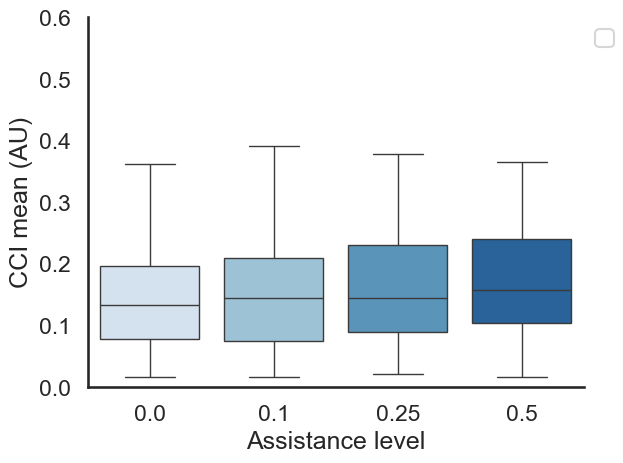

In [25]:
#  Co-contraction vs assistance
plt = sns.boxplot(data=df_assis, x='assistance', y='CCI_mean', palette="Blues")
plt.set_xlabel('Assistance level')
plt.set_ylabel('CCI mean (AU)')
plt.set(ylim=(0,0.6))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

### Truncated

C:\Users\merin\AppData\Local\Temp\ipykernel_34440\2647742586.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_assis, x='assistance', y='CCI_trunc_mean', palette="Blues")
C:\Users\merin\AppData\Local\Temp\ipykernel_34440\2647742586.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


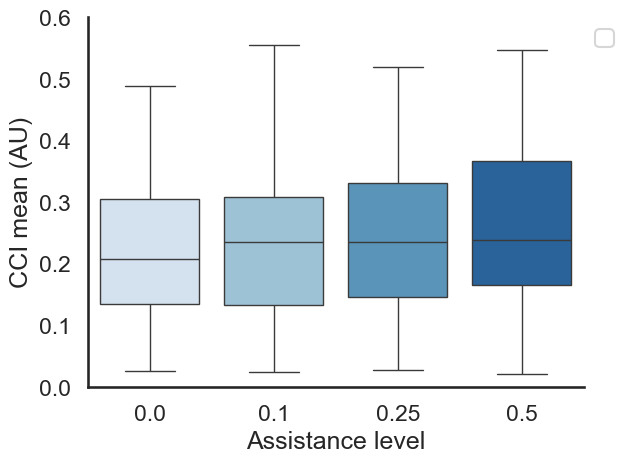

In [26]:
#  Co-contraction truncated vs assistance
plt = sns.boxplot(data=df_assis, x='assistance', y='CCI_trunc_mean', palette="Blues")
plt.set_xlabel('Assistance level')
plt.set_ylabel('CCI mean (AU)')
plt.set(ylim=(0,0.6))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

### Processed

C:\Users\merin\AppData\Local\Temp\ipykernel_34440\3237242039.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_assis, x='assistance', y='CCI_mean_from_proc', palette="Blues")
C:\Users\merin\AppData\Local\Temp\ipykernel_34440\3237242039.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


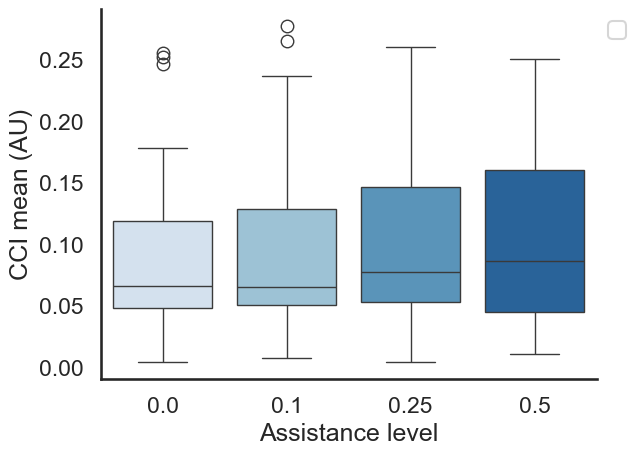

In [27]:
#  Co-contraction truncated vs assistance
plt = sns.boxplot(data=df_assis, x='assistance', y='CCI_mean_from_proc', palette="Blues")
plt.set_xlabel('Assistance level')
plt.set_ylabel('CCI mean (AU)')
# plt.set(ylim=(0,0.6))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

## Block vs co-contraction

Whole signal - Dataframe averaged by block

In [28]:
# Group by block. One ablock for each subject
df_block = df_grouped.groupby(['SN', 'block']).mean().reset_index()

# Erase block column
df_block = df_block.drop('assistance', axis=1)

# statistics on SoA between blocks
pg.anova(data=df_block, dv='CCI_mean', between='block', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,block,0.009434,5,0.001887,0.152969,0.978769,0.006664
1,Within,1.406069,114,0.012334,NaN,NaN,NaN


### Results of ANOVA
The F-statistic of 2.445271 suggests that the variability due to block is about 2.45 times the variability within the groups.
The block factor has a statistically significant effect on CCI_trunc_mean (p-value < 0.05).
The effect size measure (np2 = 0.005) indicates that the block factor explains about 0.51% of the variance in CCI_trunc_mean. This is a small effect size.

Truncated

In [29]:
# statistics on SoA between blocks
pg.anova(data=df_block, dv='CCI_trunc_mean', between='block', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,block,0.011946,5,0.002389,0.098896,0.992128,0.004319
1,Within,2.754079,114,0.024159,NaN,NaN,NaN


### Results of ANOVA
The F-statistic of 3.883963 suggests that the variability due to block is about 3.88 times the variability within the groups.
The block factor has a statistically significant effect on CCI_trunc_mean (p-value < 0.05).
The effect size measure (np2 = 0.008) indicates that the block factor explains about 0.80% of the variance in CCI_trunc_mean. This is a small effect size.


Processed

In [30]:
# statistics on SoA between blocks
pg.anova(data=df_block, dv='CCI_mean_from_proc', between='block', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,block,0.005555,5,0.001111,0.150161,0.979627,0.006543
1,Within,0.843493,114,0.007399,NaN,NaN,NaN


### Result

Assistance does not significantly influence CCI_trunc_mean (p-value = 0.0527 > 0.05), and its impact is minimal (np2 = = 0.004555).

## Plot whole

C:\Users\merin\AppData\Local\Temp\ipykernel_34440\1652384145.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_block, x='block', y='CCI_mean', palette="Blues")
C:\Users\merin\AppData\Local\Temp\ipykernel_34440\1652384145.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


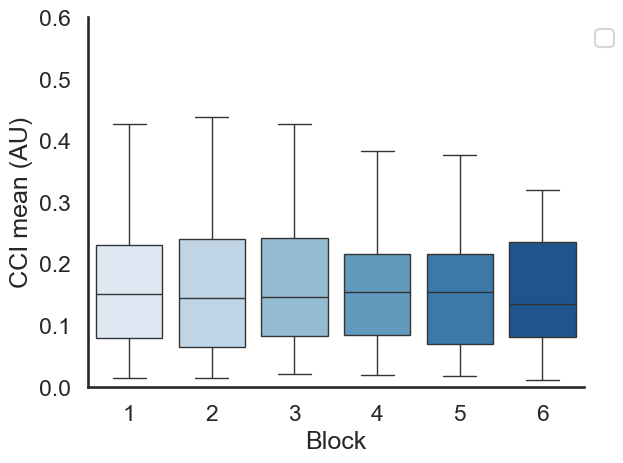

In [31]:
#  Co-contraction vs block
plt = sns.boxplot(data=df_block, x='block', y='CCI_mean', palette="Blues")
plt.set_xlabel('Block')
plt.set_ylabel('CCI mean (AU)')
plt.set(ylim=(0,0.6))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

Truncated

C:\Users\merin\AppData\Local\Temp\ipykernel_34440\1126360956.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_block, x='block', y='CCI_trunc_mean', palette="Blues")
C:\Users\merin\AppData\Local\Temp\ipykernel_34440\1126360956.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


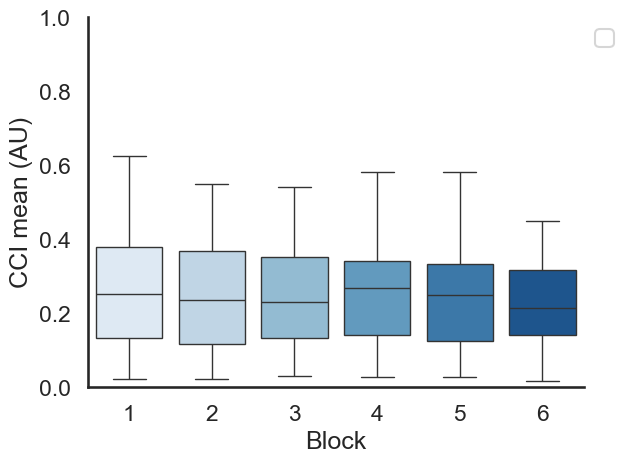

In [32]:
#  Co-contraction vs block
plt = sns.boxplot(data=df_block, x='block', y='CCI_trunc_mean', palette="Blues")
plt.set_xlabel('Block')
plt.set_ylabel('CCI mean (AU)')
plt.set(ylim=(0,1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

C:\Users\merin\AppData\Local\Temp\ipykernel_34440\2755168021.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_block, x='block', y='CCI_mean_from_proc', palette="Blues")
C:\Users\merin\AppData\Local\Temp\ipykernel_34440\2755168021.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


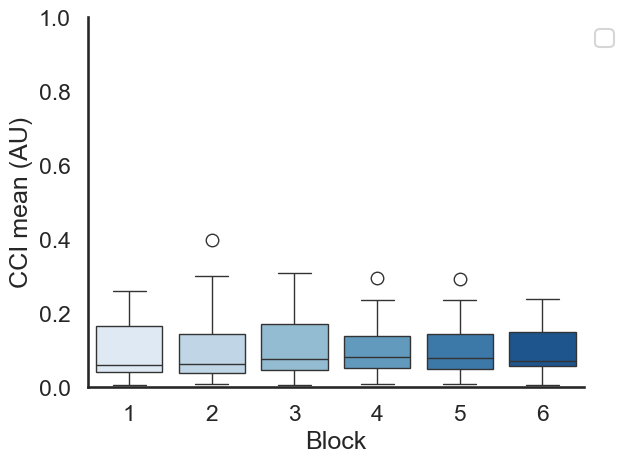

In [33]:
#  Co-contraction vs block
plt = sns.boxplot(data=df_block, x='block', y='CCI_mean_from_proc', palette="Blues")
plt.set_xlabel('Block')
plt.set_ylabel('CCI mean (AU)')
plt.set(ylim=(0,1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

C:\Users\merin\AppData\Local\Temp\ipykernel_34440\3486457319.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=merged_df, x='SN', y='CCI_mean', palette="Blues")


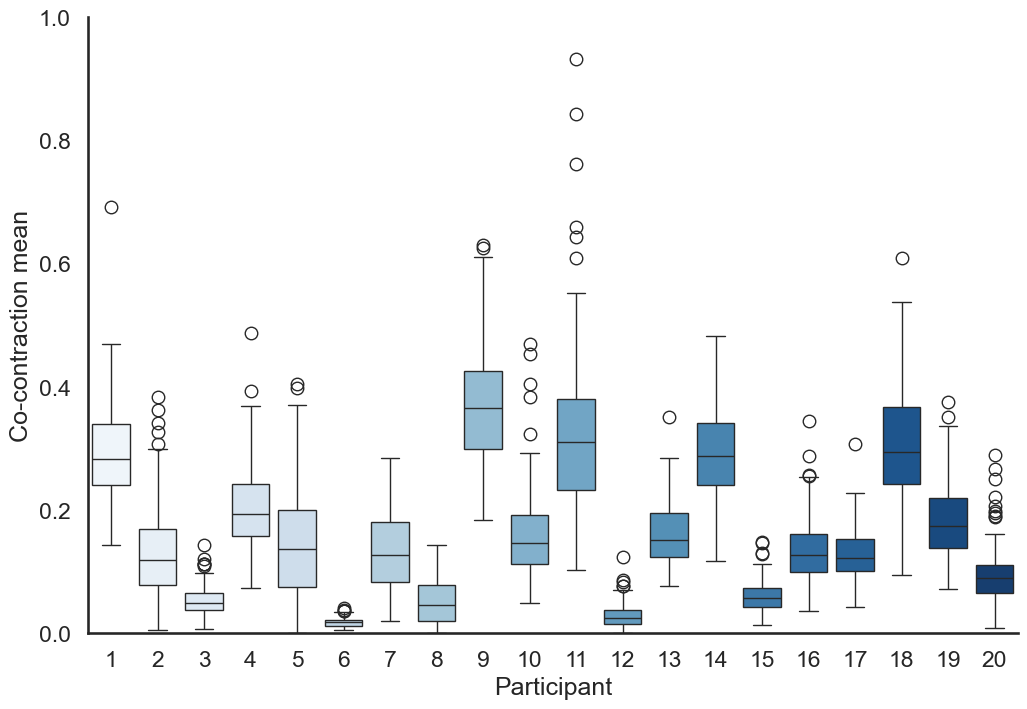

In [35]:
import matplotlib.pyplot as plt
merged_df['SN'] = merged_df['SN'] -1

#  Co-contraction vs participant
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=merged_df, x='SN', y='CCI_mean', palette="Blues")
ax.set_xlabel('Participant')
ax.set_ylabel('Co-contraction mean')
ax.set(ylim=(0, 1))

sns.despine()
plt.show()
